# Gated Linear Units (GLUs)

In this example, we will explore the use of GLUs, and see how to use Keras-MML's version of GLUs (i.e., `GLUMML`).

:::{note}
For the last part of the notebook, we will be using some plotting utilities. You are free to skip them if you want; otherwise, these additional dependencies are required.
:::

In [1]:
%pip install matplotlib~=3.9.0 seaborn~=0.13.2

Note: you may need to restart the kernel to use updated packages.


## An Introduction to GLUs

In [_Language Modeling with Gated Convolutional Networks_](https://arxiv.org/pdf/1612.08083) by Dauphin et al., they introduced GLUs, attempting to replace recurrent connections commonly found in Recurrent Neural Networks (RNNs) with gated temporal connections. The idea behind GLUs is simple: we want the neural network to moderate how much information should flow through a given path, like a logical gate.

Suppose the information that 'wants' to flow through the network is represented by the vector $\mathbf{x}$. We moderate the amount of information that is retained by the network by multiplying $\mathbf{x}$ by a constant, say $\alpha$, that is bounded in the interval $[0, 1]$. In particular, when $\alpha = 0$, no information passes through the network, and when $\alpha = 1$ all the information stored in $\mathbf{x}$ passes through.

Now we want the network to also learn how much information to flow through the network, i.e. we want the network to also learn this proposed coefficient $\alpha$. To do so, we could use a `Dense` layer to learn $\alpha$, but we need to make sure that the values produced from this step stay in the interval $[0, 1]$. That's why Dauphin et al. proposes applying the sigmoid activation to this particular layer, in order to bound the coefficient within $[0, 1]$.

In the aforementioned paper, the hidden layers are calculated using
$$
h_l(\mathbf{x}) = (\mathbf{x}\mathbf{W} + \mathbf{b}) \otimes \sigma\left(\mathbf{x}\mathbf{V} + \mathbf{c}\right)
$$
where $\mathbf{x}$ is the input of the layer $h_l$, the matrices $\mathbf{W}, \mathbf{V}$ are weights to be learned by the network, $\mathbf{b}, \mathbf{c}$ are bias vectors that are to also be learned by the network, $\sigma$ is the sigmoid function, and $\otimes$ is the element-wise product between matrices.

Of course, there's no reason why we are restricting ourselves to the sigmoid activation function. In [_GLU Variants Improve Transformer_](https://arxiv.org/pdf/2002.05202) by Shazeer, they propose alternative activation functions, creating other GLU variants:
$$
\begin{align*}
    \mathrm{ReGLU}(\mathbf{x}, \mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{c}) &= \max\left(0, \mathbf{x}\mathbf{W} + \mathbf{b}\right) \otimes (\mathbf{x}\mathbf{V} + \mathbf{c})\\
    \mathrm{GEGLU}(\mathbf{x}, \mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{c}) &= \mathrm{GELU}\left(0, \mathbf{x}\mathbf{W} + \mathbf{b}\right) \otimes (\mathbf{x}\mathbf{V} + \mathbf{c})\\
    \mathrm{SwiGLU}(\mathbf{x}, \mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{c}, \beta) &= \mathrm{Swish}_\beta\left(0, \mathbf{x}\mathbf{W} + \mathbf{b}\right) \otimes (\mathbf{x}\mathbf{V} + \mathbf{c})
\end{align*}
$$

:::{note}
The $\mathrm{Swish}$ activation function is also known as the $\mathrm{SiLU}$ (Sigmoid Linear Unit) activation function.
:::

## A Simple Example With GLUs

To demonstrate the use of GLUs, we make a simple dataset with the following rules.

1. Each feature vector is a 5-dimensional vector. For example, `[1, 0, 1, 0, 1]`.
2. If the first and third entries sum to at least 1, the output will be the input divided by 2. For example, `[1, 0, 1, 0, 1]` becomes `[0.5, 0, 0.5, 0., 0.5]`.
3. Otherwise the output will all be zeroes. For example `[0, 1, 0, 1, 0]` becomes `[0, 0, 0, 0, 0]`.

We create a dataset of 10000 entries.

In [2]:
import numpy as np

np.random.seed(42)  # For reproducibility

In [3]:
X = np.random.uniform(low=0, size=(10000, 5))

y = np.zeros_like(X)
condition = X[:, 0] + X[:, 2] >= 1
indices = np.where(condition)
y[indices] = X[indices] * 0.5

In [4]:
print(X[:5])
print(y[:5])

[[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
 [0.15599452 0.05808361 0.86617615 0.60111501 0.70807258]
 [0.02058449 0.96990985 0.83244264 0.21233911 0.18182497]
 [0.18340451 0.30424224 0.52475643 0.43194502 0.29122914]
 [0.61185289 0.13949386 0.29214465 0.36636184 0.45606998]]
[[0.18727006 0.47535715 0.36599697 0.29932924 0.07800932]
 [0.07799726 0.02904181 0.43308807 0.30055751 0.35403629]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


We use a train-test split of 9:1.

In [5]:
train_data = X[:9000], y[:9000]
test_data = X[9000:], y[9000:]

The model that we will use is a simple SwiGLU model.

In [6]:
import keras

import keras_mml

2024-06-19 07:33:34.073257: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 07:33:34.075679: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 07:33:34.110426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 07:33:35.003128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
model = keras.Sequential(
    layers=[
        keras.layers.Input(shape=(5,)),
        keras_mml.layers.GLUMML(32, activation="silu"),  # Silu is the same as Swish
        keras.layers.Dense(5)
    ], 
    name="SwiGLU-Model"
)
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)
model.summary()

Model: "SwiGLU-Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ glumml (GLUMML)                 │ (None, 32)             │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,917 (42.64 KB)

 Trainable params: 10,917 (42.64 KB)

 Non-trainable params: 0 (0.00 B)

We define a callback to print the training output once every 10 epochs. This is to reduce clutter on the screen.

In [8]:
class print_training_results_Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if int(epoch) % 10 == 0:
            print(
                f"Epoch: {epoch:>3}"
                + f" | loss: {logs['loss']:.5f}"
                + f" | mae: {logs['mae']:.5f}"
                + f" | val_loss: {logs['val_loss']:.5f}"
                + f" | val_mae: {logs['val_mae']:.5f}"
            )


Now we can train the model. We train it for 300 epochs using a batch size of 256.

In [9]:
NUM_EPOCHS = 300
BATCH_SIZE = 256

In [10]:
history = model.fit(
    train_data[0],
    train_data[1],
    validation_data=test_data,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[print_training_results_Callback()]
)

Epoch:   0 | loss: 0.04493 | mae: 0.14234 | val_loss: 0.03945 | val_mae: 0.14099
Epoch:  10 | loss: 0.02264 | mae: 0.13147 | val_loss: 0.02163 | val_mae: 0.12805
Epoch:  20 | loss: 0.01747 | mae: 0.10709 | val_loss: 0.01667 | val_mae: 0.10418
Epoch:  30 | loss: 0.01619 | mae: 0.10136 | val_loss: 0.01548 | val_mae: 0.09865
Epoch:  40 | loss: 0.01548 | mae: 0.09794 | val_loss: 0.01483 | val_mae: 0.09593
Epoch:  50 | loss: 0.01504 | mae: 0.09573 | val_loss: 0.01441 | val_mae: 0.09396
Epoch:  60 | loss: 0.01476 | mae: 0.09429 | val_loss: 0.01416 | val_mae: 0.09263
Epoch:  70 | loss: 0.01461 | mae: 0.09355 | val_loss: 0.01404 | val_mae: 0.09199
Epoch:  80 | loss: 0.01451 | mae: 0.09293 | val_loss: 0.01393 | val_mae: 0.09140
Epoch:  90 | loss: 0.01446 | mae: 0.09264 | val_loss: 0.01393 | val_mae: 0.09135
Epoch: 100 | loss: 0.01445 | mae: 0.09251 | val_loss: 0.01389 | val_mae: 0.09122
Epoch: 110 | loss: 0.01442 | mae: 0.09247 | val_loss: 0.01388 | val_mae: 0.09120
Epoch: 120 | loss: 0.01502 |

In [11]:
test_mse, test_mae = model.evaluate(test_data[0], test_data[1])
print("Test MSE:", test_mse)
print("Test MAE:", test_mae)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - mae: 0.0882 
Test MSE: 0.013556629419326782
Test MAE: 0.08931774646043777


Let's save the record of validation losses for later, so we can make a comparison between different GLU variants.

In [12]:
validation_losses = {}
validation_losses["SwiGLU"] = history.history["val_loss"]

### Other GLU Variants

Let's also try out the `GLUMML` layer on different GLU variants. We skip $\mathrm{SwiGLU}$ as we already did it above.

In [13]:
VARIANT_MAP = {
    "Bilinear": "linear",
    "GEGLU": "gelu",
    "ReGLU": "relu",
    "SeGLU": "selu"
}

In [14]:
def train_variant(variant_name):
    print(f" {variant_name} ".center(50, "="))
    activation_func = VARIANT_MAP[variant_name]
    
    model = keras.Sequential(
        layers=[
            keras.layers.Input(shape=(5,)),
            keras_mml.layers.GLUMML(32, activation=activation_func),
            keras.layers.Dense(5)
        ], 
        name=f"{variant_name}-Model"
    )
    model.compile(
        loss="mse",
        optimizer="adam",
        metrics=["mae"]
    )
    
    history = model.fit(
        train_data[0],
        train_data[1],
        validation_data=test_data,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        callbacks=[print_training_results_Callback()]
    )
    
    validation_losses[variant_name] = history.history["val_loss"]
    print()

In [15]:
for variant in VARIANT_MAP:
    train_variant(variant)

==================== Bilinear ====================
Epoch:   0 | loss: 0.04619 | mae: 0.14263 | val_loss: 0.04046 | val_mae: 0.14063
Epoch:  10 | loss: 0.02459 | mae: 0.13926 | val_loss: 0.02358 | val_mae: 0.13608
Epoch:  20 | loss: 0.01814 | mae: 0.11056 | val_loss: 0.01730 | val_mae: 0.10727
Epoch:  30 | loss: 0.01619 | mae: 0.10146 | val_loss: 0.01554 | val_mae: 0.09923
Epoch:  40 | loss: 0.01533 | mae: 0.09767 | val_loss: 0.01479 | val_mae: 0.09615
Epoch:  50 | loss: 0.01495 | mae: 0.09590 | val_loss: 0.01445 | val_mae: 0.09476
Epoch:  60 | loss: 0.01476 | mae: 0.09489 | val_loss: 0.01427 | val_mae: 0.09386
Epoch:  70 | loss: 0.01465 | mae: 0.09435 | val_loss: 0.01416 | val_mae: 0.09334
Epoch:  80 | loss: 0.01457 | mae: 0.09379 | val_loss: 0.01407 | val_mae: 0.09289
Epoch:  90 | loss: 0.01452 | mae: 0.09350 | val_loss: 0.01403 | val_mae: 0.09251
Epoch: 100 | loss: 0.01449 | mae: 0.09321 | val_loss: 0.01398 | val_mae: 0.09222
Epoch: 110 | loss: 0.01446 | mae: 0.09297 | val_loss: 0.01

## Comparison Models

Let's also define two comparison models to assess against the GLU models.

The first will be a simple MLP that uses a $\mathrm{Sigmoid}$ activation in the middle layer.

In [16]:
model = keras.Sequential(
    layers=[
        keras.layers.Input(shape=(5,)),
        keras_mml.layers.DenseMML(32),
        keras_mml.layers.DenseMML(256, activation="sigmoid"),
        keras_mml.layers.DenseMML(32),
        keras.layers.Dense(5)
    ], 
    name="Dense-With-Sigmoid-Model"
)
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)
model.summary()

Model: "Dense-With-Sigmoid-Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_mml_10 (DenseMML)         │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_mml_11 (DenseMML)         │ (None, 256)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_mml_12 (DenseMML)         │ (None, 32)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,709 (65.27 KB)

 Trainable params: 16,709 (65.27 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    train_data[0],
    train_data[1],
    validation_data=test_data,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[print_training_results_Callback()]
)
validation_losses["Dense-With-Sigmoid"] = history.history["val_loss"]

Epoch:   0 | loss: 0.04450 | mae: 0.14238 | val_loss: 0.03887 | val_mae: 0.14081
Epoch:  10 | loss: 0.02952 | mae: 0.15329 | val_loss: 0.02920 | val_mae: 0.15255
Epoch:  20 | loss: 0.02952 | mae: 0.15347 | val_loss: 0.02920 | val_mae: 0.15265
Epoch:  30 | loss: 0.02952 | mae: 0.15358 | val_loss: 0.02919 | val_mae: 0.15242
Epoch:  40 | loss: 0.02952 | mae: 0.15349 | val_loss: 0.02919 | val_mae: 0.15242
Epoch:  50 | loss: 0.02952 | mae: 0.15360 | val_loss: 0.02919 | val_mae: 0.15243
Epoch:  60 | loss: 0.02950 | mae: 0.15333 | val_loss: 0.02918 | val_mae: 0.15254
Epoch:  70 | loss: 0.02949 | mae: 0.15354 | val_loss: 0.02916 | val_mae: 0.15249
Epoch:  80 | loss: 0.02948 | mae: 0.15328 | val_loss: 0.02915 | val_mae: 0.15250
Epoch:  90 | loss: 0.02946 | mae: 0.15349 | val_loss: 0.02914 | val_mae: 0.15263
Epoch: 100 | loss: 0.02943 | mae: 0.15337 | val_loss: 0.02910 | val_mae: 0.15248
Epoch: 110 | loss: 0.02937 | mae: 0.15305 | val_loss: 0.02903 | val_mae: 0.15200
Epoch: 120 | loss: 0.02929 |

The second is similar to the first, but instead of $\mathrm{Sigmoid}$ we will use $\mathrm{ReLU}$.

In [18]:
model = keras.Sequential(
    layers=[
        keras.layers.Input(shape=(5,)),
        keras_mml.layers.DenseMML(32),
        keras_mml.layers.DenseMML(256, activation="relu"),
        keras_mml.layers.DenseMML(32),
        keras.layers.Dense(5)
    ], 
    name="Dense-With-ReLU-Model"
)
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)
model.summary()

Model: "Dense-With-ReLU-Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_mml_13 (DenseMML)         │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_mml_14 (DenseMML)         │ (None, 256)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_mml_15 (DenseMML)         │ (None, 32)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,709 (65.27 KB)

 Trainable params: 16,709 (65.27 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    train_data[0],
    train_data[1],
    validation_data=test_data,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[print_training_results_Callback()]
)
validation_losses["Dense-With-ReLU"] = history.history["val_loss"]

Epoch:   0 | loss: 0.04508 | mae: 0.14132 | val_loss: 0.03958 | val_mae: 0.13950
Epoch:  10 | loss: 0.02234 | mae: 0.12905 | val_loss: 0.02142 | val_mae: 0.12582
Epoch:  20 | loss: 0.01732 | mae: 0.10626 | val_loss: 0.01661 | val_mae: 0.10365
Epoch:  30 | loss: 0.01589 | mae: 0.09943 | val_loss: 0.01520 | val_mae: 0.09698
Epoch:  40 | loss: 0.01526 | mae: 0.09645 | val_loss: 0.01461 | val_mae: 0.09445
Epoch:  50 | loss: 0.01490 | mae: 0.09458 | val_loss: 0.01425 | val_mae: 0.09261
Epoch:  60 | loss: 0.01465 | mae: 0.09315 | val_loss: 0.01401 | val_mae: 0.09119
Epoch:  70 | loss: 0.01444 | mae: 0.09198 | val_loss: 0.01382 | val_mae: 0.09016
Epoch:  80 | loss: 0.01429 | mae: 0.09105 | val_loss: 0.01368 | val_mae: 0.08942
Epoch:  90 | loss: 0.01417 | mae: 0.09038 | val_loss: 0.01358 | val_mae: 0.08871
Epoch: 100 | loss: 0.01407 | mae: 0.08973 | val_loss: 0.01349 | val_mae: 0.08822
Epoch: 110 | loss: 0.01400 | mae: 0.08932 | val_loss: 0.01341 | val_mae: 0.08779
Epoch: 120 | loss: 0.01393 |

## Plotting Losses

Let's plot the validation losses over time.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

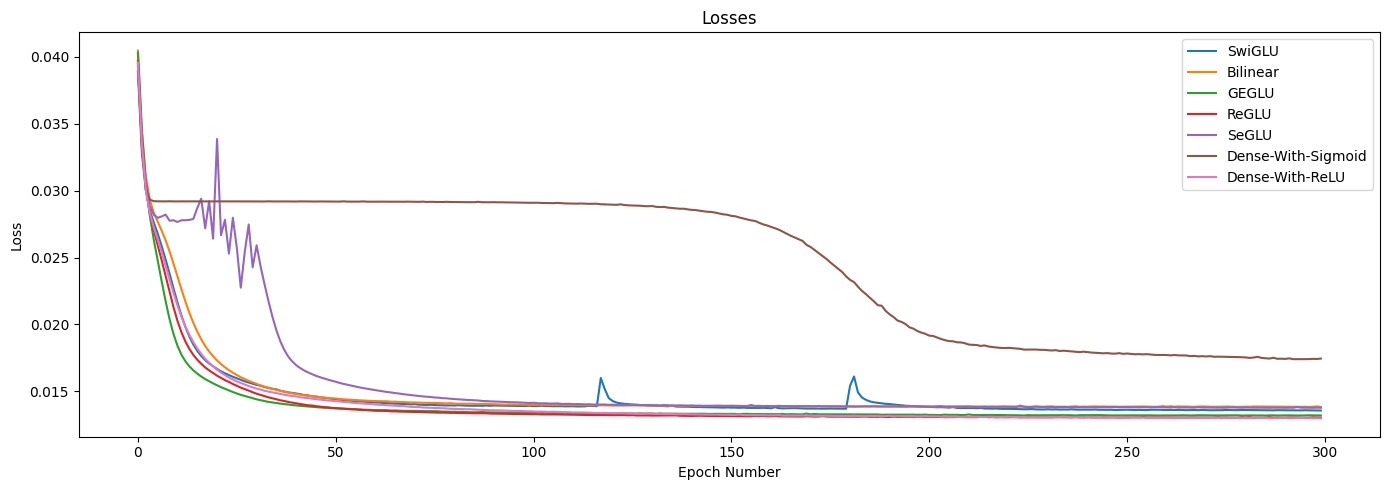

In [21]:
plt.figure(figsize=(14, 5), dpi=100)

for variant in validation_losses: 
    sns.lineplot(validation_losses[variant], label=variant)

plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch Number")
plt.title("Losses")
plt.tight_layout()

We can't really see the losses after epoch 50, so let's zoom into that part specifically. Also, `Dense-With-Sigmoid` performs very poorly, so let's exclude that from our analysis below. 

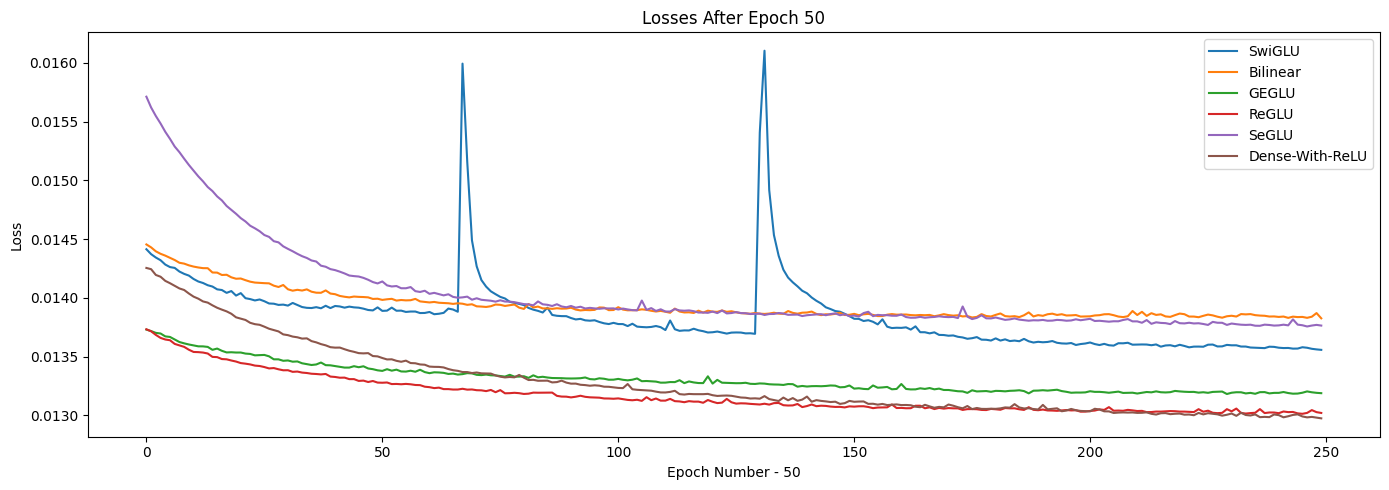

In [22]:
plt.figure(figsize=(14, 5), dpi=100)

for variant in validation_losses:
    if variant == "Dense-With-Sigmoid":
        continue
    sns.lineplot(validation_losses[variant][50:], label=variant)

plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch Number - 50")
plt.title("Losses After Epoch 50")
plt.tight_layout()

From this, we can conclude that GLU is far more stable than ReLU and, generally, learns faster than non-GLU architectures. However, it is important to note that this is just a toy example, and that GLUs may have a different performance on real datasets. It is thus important to assess all different kinds of architectures before deciding on one.